In [1]:
import sys
from pathlib import Path
import logging
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import time
import json
import re
import gc

# Setup logging and paths
logging.basicConfig(level=logging.INFO, filename='notebook.log', filemode='w')
logger = logging.getLogger(__name__)

project_root = Path('.').resolve()
src_path = project_root / 'layered-context-graph' / 'src'
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))
logger.info(f"Project root set to: {project_root}")

# Import core models
from models.baai_model import BAAIModel
from models.qwq_model import QwQModel
from partitioning.partition_manager import PartitionManager

# Import graph components with GAP enhancements
from graph.graph_objects import (
    EnrichedSegment, GraphAwareSegment, EdgeType, TypeEmbedding,
    GAPAnalysisResult, DualLevelEdge
)
from graph.graph_utils import (
    attention_to_adjacency, sparsify_graph, compute_graph_metrics,
    visualize_attention_graph, analyze_type_distribution,
    build_dual_level_graph, analyze_gap_patterns
)
from graph.attention_calculator import AttentionCalculator

# Import synthesis
from synthesis.transformer_document_builder import TransformerDocumentBuilder

In [2]:
# --- Cell 1: Model Initialization ---
# Separate models for different phases:
# - BAAI: For segmentation and embeddings (Phase 1 & 2)
# - QwQ: For reconstruction and GAP analysis (Phase 6+)

BAAI_MODEL_PATH = './bge-en-icl'
QWQ_MODEL_PATH = './QwQ_LCoT_7B_Instruct/'  # Using full model for GAP features
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("=== Model Initialization ===")
print(f"Device: {device}")

print("\nInitializing BAAIModel for segmentation...")
embedding_model = BAAIModel(model_path=BAAI_MODEL_PATH, device=device)
print("✓ BAAIModel initialized")

print("\nInitializing QwQModel for reconstruction...")
segmenter_model = QwQModel(qwq_model_path=QWQ_MODEL_PATH, device=device, enable_dual_level=True)
print("✓ QwQModel initialized with dual-level processing")

print("\n=== Models Ready ===")
print("- BAAI: Segmentation & Embeddings")
print("- QwQ: Reconstruction & GAP Analysis")

=== Model Initialization ===
Device: cuda

Initializing BAAIModel for segmentation...
✓ BAAIModel initialized

Initializing QwQModel for reconstruction...
✓ QwQModel initialized with dual-level processing

=== Models Ready ===
- BAAI: Segmentation & Embeddings
- QwQ: Reconstruction & GAP Analysis


In [3]:
# --- Cell 2: Phase 1 - Tree Construction (Tape to Tree) ---
# This phase uses BAAI model for segmentation
import psutil
import gc
from tqdm import tqdm

# Enable CUDA optimizations
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    torch.cuda.empty_cache()

start_time = time.time()
pipeline_text = open('Layer_Context_Window_Graphs', 'r').read() if Path('Layer_Context_Window_Graphs').exists() else "The sun rises in the east. Birds sing. Later, the topic shifts to astrophysics. The lifecycle of a star is complex. Returning to our original theme, the weather is warm."

print(f"Processing text with {len(pipeline_text)} characters...")

# Define segmentation rules (K=2 rules applied once per level)
# Updated first rule to specifically handle code blocks
segmentation_rules = [
    "Isolate code blocks as atomic units and separate mathematical formulas.",
    "Split into paragraphs based on semantic shifts."
]

# Initialize the manager with GraphAwareSegment support
USE_GRAPH_AWARE = True  # Enable GraphAwareSegment for richer analysis
manager = PartitionManager(similarity_threshold=0.7, use_graph_aware=USE_GRAPH_AWARE)
manager.initialize_graph(pipeline_text)

print(f"Using {'GraphAwareSegment' if USE_GRAPH_AWARE else 'EnrichedSegment'} for segment representation")

# Memory monitoring
memory_monitor = []
initial_memory = psutil.Process().memory_info().rss / 1024 / 1024 / 1024  # GB
print(f"Initial memory usage: {initial_memory:.2f} GB")

# ===== PHASE 1: TREE CONSTRUCTION (OPTIMIZED) =====
print("\n" + "="*60)
print("PHASE 1: HIERARCHICAL TREE CONSTRUCTION (OPTIMIZED)")
print("="*60)

tree_construction_start = time.time()
level = 0
MAX_LEVELS = 5  # Limit tree depth for performance

# Optimized segmentation: Process nodes in batches with immediate rule application
while manager.has_unprocessed_leaves() and level < MAX_LEVELS:
    print(f"\n--- Processing Level {level + 1} ---")
    
    # Get current level leaves
    current_level_nodes = manager.get_leaves_to_process()
    
    if not current_level_nodes:
        break
    
    print(f"Processing {len(current_level_nodes)} segments at this level")
    
    # OPTIMIZED: Process nodes with early termination
    # Apply each rule to ALL nodes, but stop processing a node once it's successfully split
    total_operations = len(current_level_nodes) * len(segmentation_rules)
    nodes_split = 0
    operations_completed = 0
    atomic_nodes_found = 0  # Track code blocks marked as atomic
    
    with tqdm(total=total_operations, desc=f"Level {level + 1}") as pbar:
        
        # Apply each rule to all unsplit nodes
        for rule_idx, rule in enumerate(segmentation_rules):
            unsplit_nodes = [node for node in current_level_nodes 
                           if not manager.is_fully_processed(node.id, [rule])
                           and not node.metadata.get('atomic', False)]  # Skip atomic nodes
            
            if not unsplit_nodes:
                # All nodes have been processed by this rule
                pbar.update(len(current_level_nodes))
                operations_completed += len(current_level_nodes)
                continue
            
            print(f"  Applying rule {rule_idx + 1} to {len(unsplit_nodes)} remaining nodes")
            
            for segment_to_split in unsplit_nodes:
                # Monitor memory
                current_memory = psutil.Process().memory_info().rss / 1024 / 1024 / 1024
                memory_monitor.append(current_memory)
                
                # Update progress
                pbar.set_postfix({
                    'rule': rule_idx + 1,
                    'split': nodes_split,
                    'atomic': atomic_nodes_found,
                    'mem_GB': f"{current_memory:.2f}",
                    'node': segment_to_split.id[:8]
                })
                
                # Apply segmentation using BAAI model
                segment_start = time.time()
                new_content_pieces = embedding_model.segment(rule, segment_to_split.content)
                segment_time = time.time() - segment_start
                
                # Check if segmentation was successful
                if len(new_content_pieces) > 1:
                    # Successful split - add children
                    manager.add_child_segments(segment_to_split.id, new_content_pieces, level=level + 1)
                    manager.mark_processed(segment_to_split.id, rule)
                    nodes_split += 1
                    
                    # Count atomic nodes (code blocks)
                    for child_id in segment_to_split.children:
                        if manager.segments[child_id].metadata.get('atomic', False):
                            atomic_nodes_found += 1
                    
                    # Log slow operations
                    if segment_time > 2.0:
                        pbar.write(f"    Slow split: {segment_to_split.id[:8]} took {segment_time:.2f}s")
                else:
                    # Mark as processed even if not split
                    manager.mark_processed(segment_to_split.id, rule)
                
                operations_completed += 1
                pbar.update(1)
                
                # Performance optimization: Clear CUDA cache periodically
                if device.type == 'cuda' and operations_completed % 10 == 0:
                    torch.cuda.empty_cache()
                
                # Early termination if memory gets too high
                if current_memory > initial_memory + 4.0:  # 4GB increase limit
                    pbar.write(f"    Memory limit reached ({current_memory:.2f}GB), stopping level")
                    break
            
            # If memory limit reached, break from rule loop too
            if memory_monitor and memory_monitor[-1] > initial_memory + 4.0:
                break
    
    print(f"  Level {level + 1} complete: {nodes_split} nodes split from {len(current_level_nodes)} candidates")
    if atomic_nodes_found > 0:
        print(f"  Found {atomic_nodes_found} atomic code blocks")
    
    level += 1
    
    # Performance check: If very few nodes were split, consider stopping
    if nodes_split < len(current_level_nodes) * 0.1 and level > 2:
        print(f"  Low split rate ({nodes_split}/{len(current_level_nodes)}), stopping tree construction")
        break

# Mark tree construction as complete
manager.complete_tree_construction()
tree_construction_end = time.time()

# Display tree statistics
tree_stats = manager.get_tree_statistics()
print(f"\n{'='*60}")
print("TREE CONSTRUCTION COMPLETE")
print(f"{'='*60}")
print(f"Tree depth: {tree_stats['tree_depth']}")
print(f"Total nodes: {tree_stats['total_nodes']}")
print(f"Leaf nodes: {tree_stats['leaf_nodes']}")
print(f"\nNodes per level:")
for lvl, count in tree_stats['nodes_per_level'].items():
    print(f"  Level {lvl}: {count} nodes")
print(f"\nAverage branching factors:")
for lvl, factor in tree_stats['branching_factors'].items():
    print(f"  Level {lvl}: {factor:.2f}")

# Count special nodes (code/math detection is now in PartitionManager)
code_nodes = sum(1 for seg in manager.segments.values() if seg.has_code)
math_nodes = sum(1 for seg in manager.segments.values() if seg.has_math)
atomic_nodes = sum(1 for seg in manager.segments.values() if seg.metadata.get('atomic', False))
print(f"\nSpecial nodes detected:")
print(f"  Code blocks: {code_nodes}")
print(f"  Math blocks: {math_nodes}")
print(f"  Atomic nodes: {atomic_nodes}")

# Check for explains edges
explains_edges = sum(1 for _, _, d in manager.graph.edges(data=True) 
                    if d.get('edge_type') == EdgeType.EXPLAINS.value)
print(f"  EXPLAINS edges: {explains_edges}")

print(f"\nTree construction time: {tree_construction_end - tree_construction_start:.2f} seconds")
print(f"Peak memory usage: {max(memory_monitor):.2f} GB")

# Show efficiency metrics
efficiency_metrics = {
    'nodes_per_second': tree_stats['total_nodes'] / (tree_construction_end - tree_construction_start),
    'memory_efficiency': tree_stats['total_nodes'] / max(memory_monitor) if memory_monitor else 0,
    'tree_balance': tree_stats['total_nodes'] / (tree_stats['tree_depth'] + 1) if tree_stats['tree_depth'] > 0 else 0
}
print(f"\nEfficiency metrics:")
print(f"  Nodes/second: {efficiency_metrics['nodes_per_second']:.1f}")
print(f"  Nodes/GB: {efficiency_metrics['memory_efficiency']:.1f}")
print(f"  Tree balance: {efficiency_metrics['tree_balance']:.1f}")

# Store Phase 1 results
phase1_results = {
    'tree_stats': tree_stats,
    'tree_construction_time': tree_construction_end - tree_construction_start,
    'peak_memory_gb': max(memory_monitor) if memory_monitor else initial_memory,
    'code_nodes': code_nodes,
    'math_nodes': math_nodes,
    'atomic_nodes': atomic_nodes,
    'explains_edges': explains_edges,
    'efficiency_metrics': efficiency_metrics
}

# ==== MEMORY CLEANUP AFTER PHASE 1 ====
print("\n--- Memory Cleanup ---")
# Clear any temporary variables
if 'current_level_nodes' in locals():
    del current_level_nodes
if 'unsplit_nodes' in locals():
    del unsplit_nodes
if 'segment_to_split' in locals():
    del segment_to_split
if 'new_content_pieces' in locals():
    del new_content_pieces

# Clear CUDA cache and run garbage collection
if device.type == 'cuda':
    before_cleanup = torch.cuda.memory_allocated() / 1024**3
    torch.cuda.empty_cache()
    after_cleanup = torch.cuda.memory_allocated() / 1024**3
    print(f"GPU memory cleaned: {before_cleanup:.2f}GB -> {after_cleanup:.2f}GB")

gc.collect()
print("✓ Memory cleanup complete")

print("\n✓ Phase 1 complete: Tree structure created efficiently with atomic code blocks")

Processing text with 105039 characters...
Using GraphAwareSegment for segment representation
Initial memory usage: 0.78 GB

PHASE 1: HIERARCHICAL TREE CONSTRUCTION (OPTIMIZED)

--- Processing Level 1 ---
Processing 1 segments at this level


Level 1:  50%|█████     | 1/2 [00:00<00:00, 30.47it/s, rule=2, split=1, atomic=107, mem_GB=0.78, node=1094d9b2]

  Applying rule 1 to 1 remaining nodes
  Applying rule 2 to 1 remaining nodes
Model device: meta
Model device after loading: cuda:0


Level 1: 100%|██████████| 2/2 [01:13<00:00, 36.57s/it, rule=2, split=1, atomic=107, mem_GB=0.78, node=1094d9b2]


    Slow split: 1094d9b2 took 73.09s
  Level 1 complete: 2 nodes split from 1 candidates
  Found 130 atomic code blocks

--- Processing Level 2 ---
Processing 111 segments at this level


Level 2:  50%|█████     | 111/222 [00:00<00:00, 837.58it/s, rule=2, split=65, atomic=0, mem_GB=2.01, node=1b26f03e]

  Applying rule 1 to 111 remaining nodes
  Applying rule 2 to 111 remaining nodes


Level 2: 100%|██████████| 222/222 [00:16<00:00, 13.37it/s, rule=2, split=89, atomic=0, mem_GB=2.01, node=98cdf63b] 


  Level 2 complete: 89 nodes split from 111 candidates

--- Processing Level 3 ---
Processing 397 segments at this level


Level 3:  27%|██▋       | 214/794 [00:00<00:00, 1082.10it/s, rule=1, split=0, atomic=0, mem_GB=2.01, node=c42f52d8]

  Applying rule 1 to 397 remaining nodes


Level 3:  51%|█████     | 403/794 [00:00<00:00, 1081.19it/s, rule=2, split=49, atomic=0, mem_GB=2.01, node=135247ec]

  Applying rule 2 to 397 remaining nodes


Level 3: 100%|██████████| 794/794 [00:28<00:00, 27.57it/s, rule=2, split=77, atomic=0, mem_GB=2.01, node=958a56de]  


  Level 3 complete: 78 nodes split from 397 candidates

--- Processing Level 4 ---
Processing 262 segments at this level


Level 4:  42%|████▏     | 219/524 [00:00<00:00, 1075.26it/s, rule=1, split=0, atomic=0, mem_GB=2.01, node=676b0650]

  Applying rule 1 to 262 remaining nodes


Level 4:  50%|█████     | 264/524 [00:00<00:00, 1111.39it/s, rule=2, split=21, atomic=0, mem_GB=2.01, node=bc086da4]

  Applying rule 2 to 262 remaining nodes


Level 4: 100%|██████████| 524/524 [00:20<00:00, 25.23it/s, rule=2, split=50, atomic=0, mem_GB=2.01, node=81b574ed]  


  Level 4 complete: 51 nodes split from 262 candidates

--- Processing Level 5 ---
Processing 143 segments at this level


Level 5:  51%|█████     | 145/286 [00:00<00:00, 1089.86it/s, rule=2, split=17, atomic=0, mem_GB=2.01, node=67956162]

  Applying rule 1 to 143 remaining nodes
  Applying rule 2 to 143 remaining nodes


Level 5: 100%|██████████| 286/286 [00:15<00:00, 18.29it/s, rule=2, split=46, atomic=0, mem_GB=2.01, node=9b5d6ab2]  

  Level 5 complete: 47 nodes split from 143 candidates

TREE CONSTRUCTION COMPLETE
Tree depth: 5
Total nodes: 1161
Leaf nodes: 969

Nodes per level:
  Level 0: 1 nodes
  Level 1: 241 nodes
  Level 2: 397 nodes
  Level 3: 262 nodes
  Level 4: 143 nodes
  Level 5: 117 nodes

Average branching factors:
  Level 0: 30.00
  Level 1: 0.84
  Level 2: 0.40
  Level 3: 0.23
  Level 4: 0.24

Special nodes detected:
  Code blocks: 131
  Math blocks: 0
  Atomic nodes: 130
  EXPLAINS edges: 217

Tree construction time: 154.96 seconds
Peak memory usage: 2.01 GB

Efficiency metrics:
  Nodes/second: 7.5
  Nodes/GB: 578.7
  Tree balance: 193.5

--- Memory Cleanup ---
GPU memory cleaned: 26.50GB -> 26.50GB
✓ Memory cleanup complete

✓ Phase 1 complete: Tree structure created efficiently with atomic code blocks


=== TREE STRUCTURE VISUALIZATION ===


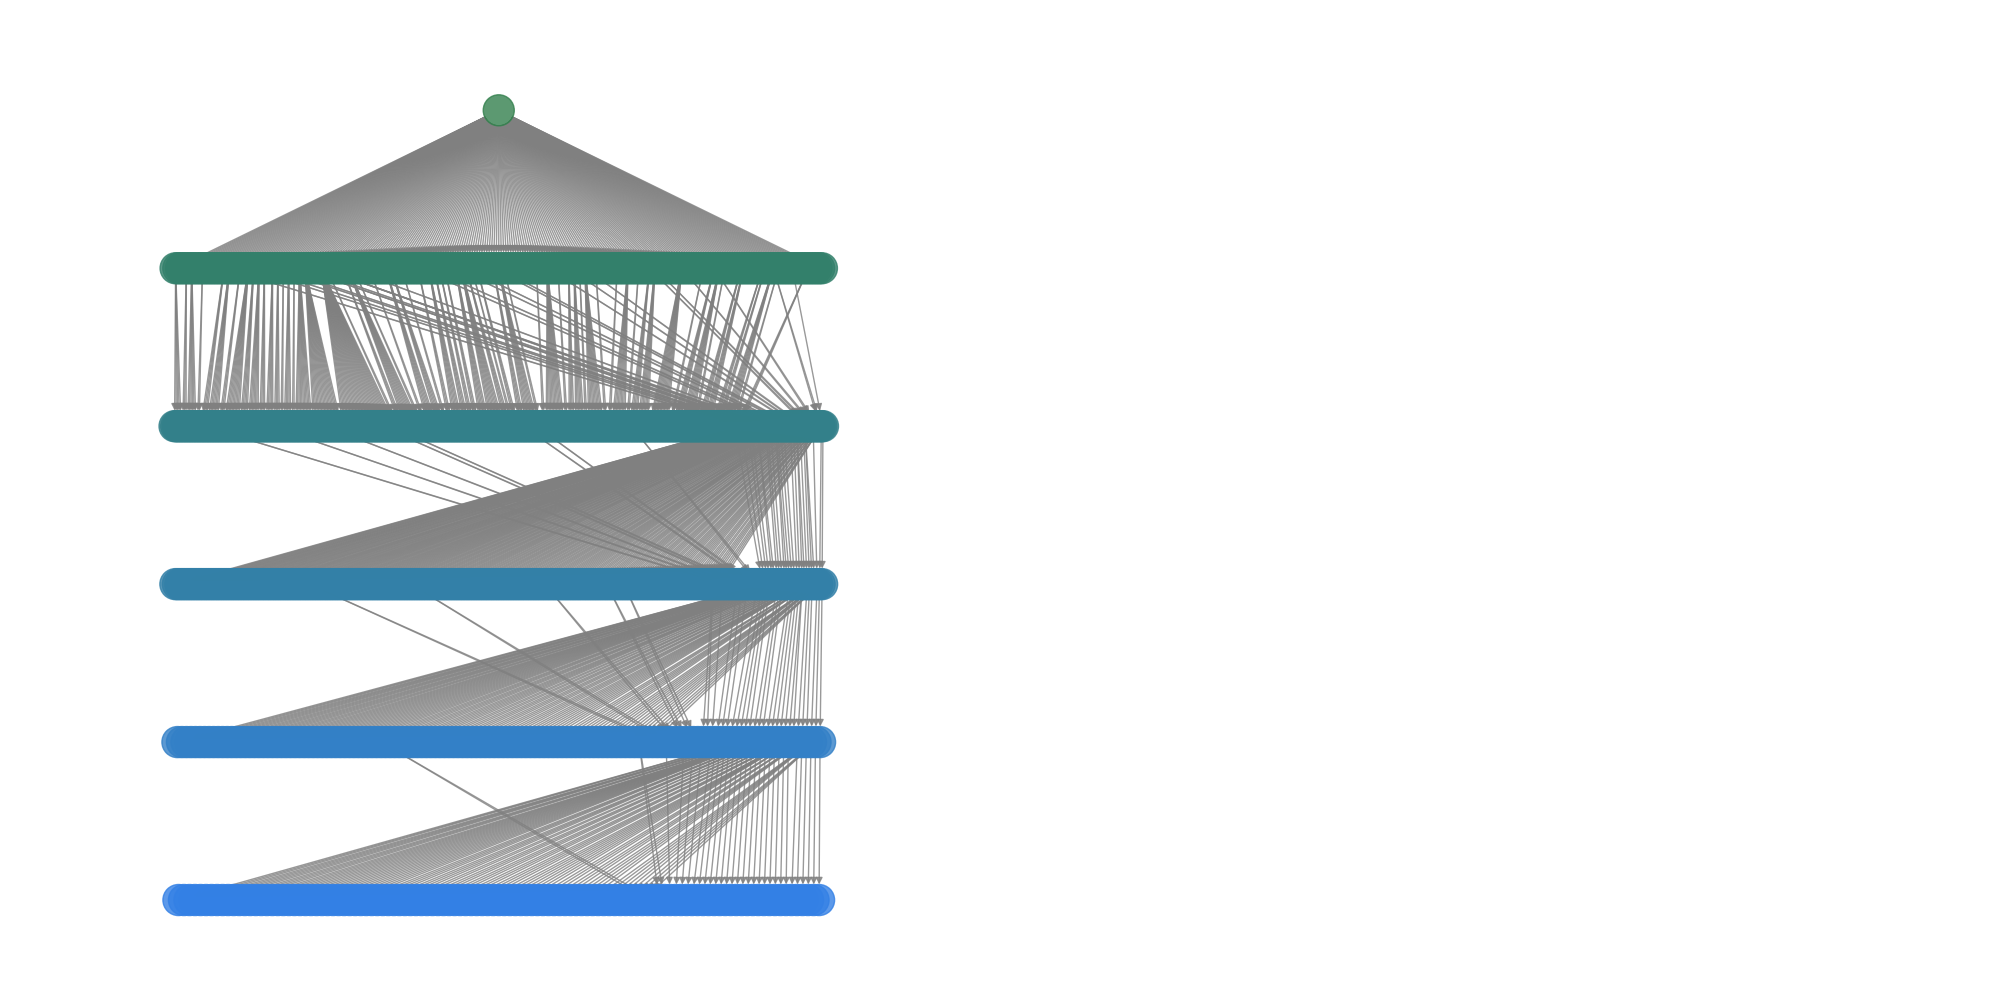

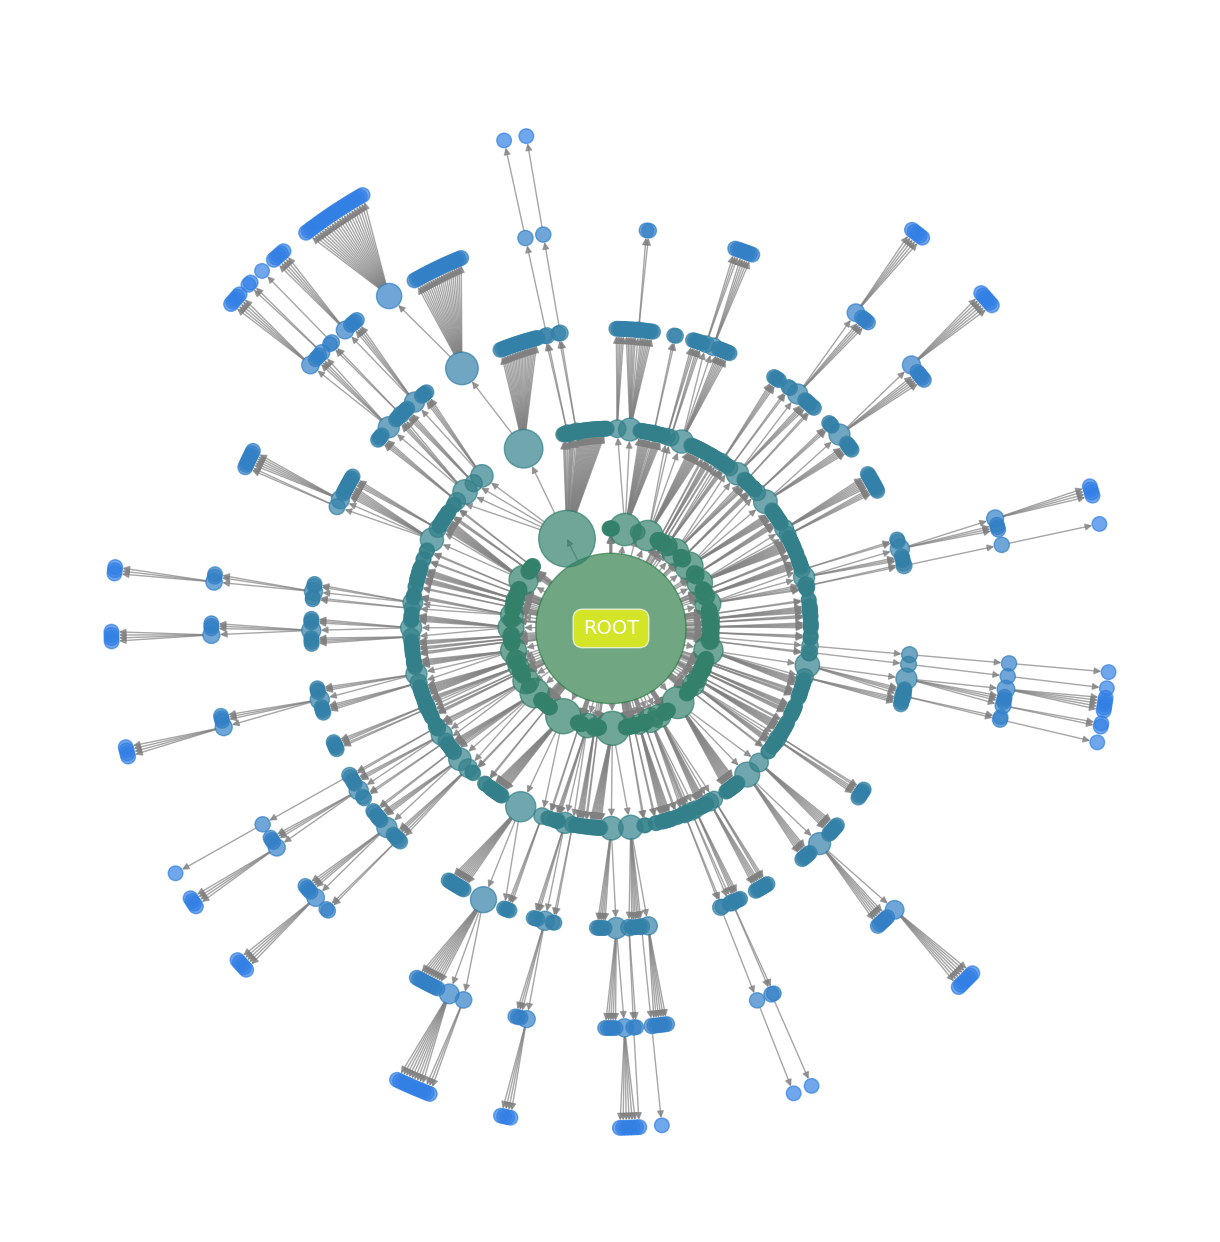


=== Tree Visualization Complete ===


In [4]:
# --- Cell 3.5: Tree Structure Visualization ---
print("=== TREE STRUCTURE VISUALIZATION ===")

# Create tree visualization
tree_graph = nx.DiGraph()

# Add only hierarchical edges for tree visualization
for u, v, data in manager.graph.edges(data=True):
    if data.get('type') == 'hierarchical':
        tree_graph.add_edge(u, v)

# Add all nodes with their metadata
for node_id, node_data in manager.graph.nodes(data=True):
    tree_graph.add_node(node_id, **node_data)

# Create hierarchical layout
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# First subplot: Tree structure with levels
if tree_graph.nodes():
    # Calculate positions using hierarchical layout
    pos = {}
    for level, nodes in manager.nodes_by_level.items():
        y = -level  # Negative so root is at top
        x_spacing = 2.0 / (len(nodes) + 1) if nodes else 1
        for i, node_id in enumerate(nodes):
            x = (i + 1) * x_spacing - 1  # Center around 0
            pos[node_id] = (x, y)
    
    # Node colors by level
    node_colors = []
    for node_id in tree_graph.nodes():
        level = manager._get_node_level(node_id)
        # Create gradient from light to dark based on level
        color_intensity = 0.3 + (level / max(manager.tree_depth, 1)) * 0.6
        node_colors.append((0.2, 0.5, color_intensity))
    
    # Draw tree
    nx.draw(tree_graph, pos, ax=ax1, 
            node_color=node_colors,
            node_size=500,
            with_labels=False,
            arrows=True,
            edge_color='gray',
            alpha=0.8)
    
    # Add level labels
    for level in range(manager.tree_depth + 1):
        ax1.text(-1.2, -level, f"Level {level}", 
                fontsize=12, va='center', ha='right')
    
    ax1.set_title(f'Hierarchical Tree Structure (Depth: {manager.tree_depth})')
    ax1.set_xlim(-1.5, 1.5)
    ax1.set_ylim(-manager.tree_depth - 0.5, 0.5)

# Second subplot: Tree statistics
ax2.axis('off')

# Collect statistics
stats_text = "TREE STATISTICS\n" + "="*30 + "\n\n"
stats_text += f"Total Nodes: {tree_stats['total_nodes']}\n"
stats_text += f"Tree Depth: {tree_stats['tree_depth']}\n"
stats_text += f"Leaf Nodes: {tree_stats['leaf_nodes']}\n\n"

stats_text += "Nodes per Level:\n"
for level, count in sorted(tree_stats['nodes_per_level'].items()):
    bar = "█" * int(count / max(tree_stats['nodes_per_level'].values()) * 20)
    stats_text += f"  Level {level}: {bar} {count}\n"

stats_text += "\nBranching Factors:\n"
for level, factor in sorted(tree_stats['branching_factors'].items()):
    stats_text += f"  Level {level}: {factor:.2f}\n"

# Calculate tree balance
if tree_stats['total_nodes'] > 1:
    # Perfect binary tree would have 2^(d+1) - 1 nodes
    perfect_nodes = 2**(tree_stats['tree_depth'] + 1) - 1
    balance_ratio = tree_stats['total_nodes'] / perfect_nodes
    stats_text += f"\nTree Balance: {balance_ratio:.2%}"

ax2.text(0.1, 0.9, stats_text, transform=ax2.transAxes,
         fontsize=12, va='top', ha='left', family='monospace')

plt.tight_layout()
plt.show()

# Create a radial tree layout for better visualization of large trees
if len(tree_graph.nodes()) > 20:
    plt.figure(figsize=(12, 12))
    
    # Use radial layout
    pos_radial = nx.nx_agraph.graphviz_layout(tree_graph, prog='twopi', root=manager.root_id) if manager.root_id else nx.spring_layout(tree_graph)
    
    # Node sizes based on subtree size
    node_sizes = []
    for node in tree_graph.nodes():
        subtree_size = len(nx.descendants(tree_graph, node)) + 1
        node_sizes.append(100 + subtree_size * 10)
    
    nx.draw(tree_graph, pos_radial,
            node_color=node_colors,
            node_size=node_sizes,
            with_labels=False,
            arrows=True,
            edge_color='gray',
            alpha=0.7)
    
    # Add root label
    if manager.root_id:
        x, y = pos_radial[manager.root_id]
        plt.text(x, y, 'ROOT', fontsize=14, ha='center', va='center',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7))
    
    plt.title('Radial Tree Layout')
    plt.axis('equal')
    plt.show()

print("\n=== Tree Visualization Complete ===")

In [5]:
# --- Cell 4: Phase 2 - Graph Enhancement (Tree to Graph) ---
# This phase adds semantic edges to create a graph from the tree

print("\n" + "="*60)
print("PHASE 2: GRAPH ENHANCEMENT WITH SEMANTIC EDGES")
print("="*60)

graph_construction_start = time.time()

# Get all segments for embedding
segments_for_embedding = manager.get_all_segments_for_embedding()
contents = [seg['content'] for seg in segments_for_embedding]

print(f"\nProcessing {len(segments_for_embedding)} segments for embeddings...")

# Compute embeddings using BAAI model
print("Computing BAAI embeddings...")
try:
    embeddings = embedding_model.encode(contents, batch_size=32, show_progress_bar=True)
except:
    # Fallback without progress bar if not supported
    embeddings = embedding_model.encode(contents, batch_size=32)

# Create embedding dictionary
embedding_dict = {
    seg['id']: embeddings[i] 
    for i, seg in enumerate(segments_for_embedding)
}

# Convert tree to graph with semantic edges
print("\nAdding semantic similarity edges...")
edges_added = manager.convert_tree_to_graph(embedding_dict, similarity_threshold=manager.similarity_threshold)

# Initialize TypeEmbedding system
type_embeddings = TypeEmbedding.create_default_embeddings()
print(f"\nInitialized edge type embeddings: {list(type_embeddings.keys())}")

# Optional: Add edge types using model classification
CLASSIFY_EDGES = False  # DISABLED to prevent memory spike from QwQ model
edge_type_count = 0

if CLASSIFY_EDGES:
    print("\nClassifying edge types...")
    edges_to_classify = [e for e in manager.graph.edges() if manager.graph[e[0]][e[1]].get('type') == 'semantic_similarity']
    
    # Limit edge classification for performance
    max_edges_to_classify = min(len(edges_to_classify), 20)  # Reduced from 100 to 20
    if len(edges_to_classify) > max_edges_to_classify:
        print(f"Note: Classifying only {max_edges_to_classify} of {len(edges_to_classify)} semantic edges for performance")
        # Sample edges evenly
        step = len(edges_to_classify) // max_edges_to_classify
        edges_to_classify = edges_to_classify[::step][:max_edges_to_classify]
    
    with tqdm(total=len(edges_to_classify), desc="Classifying edges") as pbar:
        for edge in edges_to_classify:
            source_id, target_id = edge
            source_content = manager.segments[source_id].content
            target_content = manager.segments[target_id].content
            
            # Skip classification for very short segments
            if len(source_content) < 20 or len(target_content) < 20:
                edge_type = EdgeType.NO_RELATION
            else:
                # Use QwQ model for relationship classification
                edge_type_str = segmenter_model.classify_relationship(source_content, target_content)
                
                # Map to EdgeType
                edge_type_map = {
                    'explains': EdgeType.EXPLAINS,
                    'elaborates': EdgeType.ELABORATES,
                    'contradicts': EdgeType.CONTRADICTS,
                    'is_example_of': EdgeType.IS_EXAMPLE_OF,
                    'is_consequence_of': EdgeType.IS_CONSEQUENCE_OF,
                    'depends_on': EdgeType.DEPENDS_ON,
                    'unknown': EdgeType.NO_RELATION
                }
                edge_type = edge_type_map.get(edge_type_str, EdgeType.NO_RELATION)
            
            # Update edge data
            manager.graph[source_id][target_id]['edge_type'] = edge_type.value
            manager.graph[source_id][target_id]['type_name'] = edge_type.name
            edge_type_count += 1
            
            pbar.update(1)
            
            # Clear GPU cache periodically during classification
            if edge_type_count % 5 == 0 and device.type == 'cuda':
                torch.cuda.empty_cache()

graph_construction_end = time.time()

# Graph statistics
hierarchical_edges = sum(1 for _, _, d in manager.graph.edges(data=True) if d.get('type') == 'hierarchical')
semantic_edges = sum(1 for _, _, d in manager.graph.edges(data=True) if d.get('type') == 'semantic_similarity')

print(f"\n{'='*60}")
print("GRAPH ENHANCEMENT COMPLETE")
print(f"{'='*60}")
print(f"Hierarchical edges (tree): {hierarchical_edges}")
print(f"Semantic similarity edges: {semantic_edges}")
print(f"Total edges: {manager.graph.number_of_edges()}")
print(f"Edge density: {manager.graph.number_of_edges() / (len(manager.segments) * (len(manager.segments) - 1)):.3f}")
if CLASSIFY_EDGES:
    print(f"Classified edge types: {edge_type_count}")
else:
    print("Edge classification disabled to prevent memory spike")

# GraphAwareSegment analysis
if USE_GRAPH_AWARE and isinstance(next(iter(manager.segments.values())), GraphAwareSegment):
    print("\n--- GraphAwareSegment Network Analysis ---")
    
    # Find hub nodes
    hub_nodes = [seg for seg in manager.segments.values() if seg.is_hub_node]
    print(f"Hub nodes identified: {len(hub_nodes)}")
    
    # Show top hub nodes
    if hub_nodes:
        print("\nTop hub nodes by connectivity:")
        sorted_hubs = sorted(hub_nodes, key=lambda s: s.attention_density, reverse=True)[:5]
        for hub in sorted_hubs:
            total_edges = len(hub.incoming_edges) + len(hub.outgoing_edges)
            print(f"  {hub.id[:8]}: {total_edges} edges, density={hub.attention_density:.3f}")
            print(f"    Content preview: {hub.content[:50]}...")

print(f"\nGraph enhancement time: {graph_construction_end - graph_construction_start:.2f} seconds")

# Store Phase 2 results
phase2_results = {
    'graph_enhancement_time': graph_construction_end - graph_construction_start,
    'hierarchical_edges': hierarchical_edges,
    'semantic_edges': semantic_edges,
    'edge_types_classified': edge_type_count,
    'embeddings': embeddings,  # Keep for reference but will clean up GPU memory
    'embedding_dict': embedding_dict,
    'type_embeddings': type_embeddings
}

# ==== MEMORY CLEANUP AFTER PHASE 2 ====
print("\n--- Memory Cleanup (Phase 2) ---")

# Clean up temporary variables but keep models loaded
if 'contents' in locals():
    del contents
if 'segments_for_embedding' in locals():
    del segments_for_embedding
if 'edges_to_classify' in locals():
    del edges_to_classify

# Convert embeddings to CPU to free GPU memory (if they're on GPU)
if isinstance(embeddings, torch.Tensor) and embeddings.is_cuda:
    phase2_results['embeddings'] = embeddings.cpu()
    del embeddings

# Convert embedding_dict values to CPU
if 'embedding_dict' in locals():
    cpu_embedding_dict = {}
    for k, v in embedding_dict.items():
        if isinstance(v, torch.Tensor) and v.is_cuda:
            cpu_embedding_dict[k] = v.cpu()
        elif isinstance(v, np.ndarray):
            cpu_embedding_dict[k] = v
        else:
            cpu_embedding_dict[k] = v
    phase2_results['embedding_dict'] = cpu_embedding_dict
    del embedding_dict

# Clear CUDA cache but keep models loaded
if device.type == 'cuda':
    before_cleanup = torch.cuda.memory_allocated() / 1024**3
    torch.cuda.empty_cache()
    after_cleanup = torch.cuda.memory_allocated() / 1024**3
    print(f"GPU memory cleaned: {before_cleanup:.2f}GB -> {after_cleanup:.2f}GB")
    print(f"Models still loaded in GPU memory")

gc.collect()
print("✓ Memory cleanup complete (models preserved)")

print("\n✓ Phase 2 complete: Graph structure enhanced with semantic edges")


PHASE 2: GRAPH ENHANCEMENT WITH SEMANTIC EDGES

Processing 1161 segments for embeddings...
Computing BAAI embeddings...

Adding semantic similarity edges...

Initialized edge type embeddings: [<EdgeType.NO_RELATION: 0>, <EdgeType.EXPLAINS: 1>, <EdgeType.ELABORATES: 2>, <EdgeType.CONTRADICTS: 3>, <EdgeType.IS_EXAMPLE_OF: 4>, <EdgeType.IS_CONSEQUENCE_OF: 5>, <EdgeType.DEPENDS_ON: 6>, <EdgeType.SUMMARIZES: 7>, <EdgeType.REFERENCES: 8>, <EdgeType.CONTINUES: 9>]

GRAPH ENHANCEMENT COMPLETE
Hierarchical edges (tree): 1160
Semantic similarity edges: 180619
Total edges: 181996
Edge density: 0.135
Edge classification disabled to prevent memory spike

--- GraphAwareSegment Network Analysis ---
Hub nodes identified: 679

Top hub nodes by connectivity:
  df1cbc88: 762 edges, density=0.657
    Content preview: *Type: Technical Core | Importance: 12.0*...
  53b460ce: 753 edges, density=0.649
    Content preview: ### Real-World Applications...
  78e0eb56: 741 edges, density=0.639
    Content preview

NameError: name 'color_map' is not defined

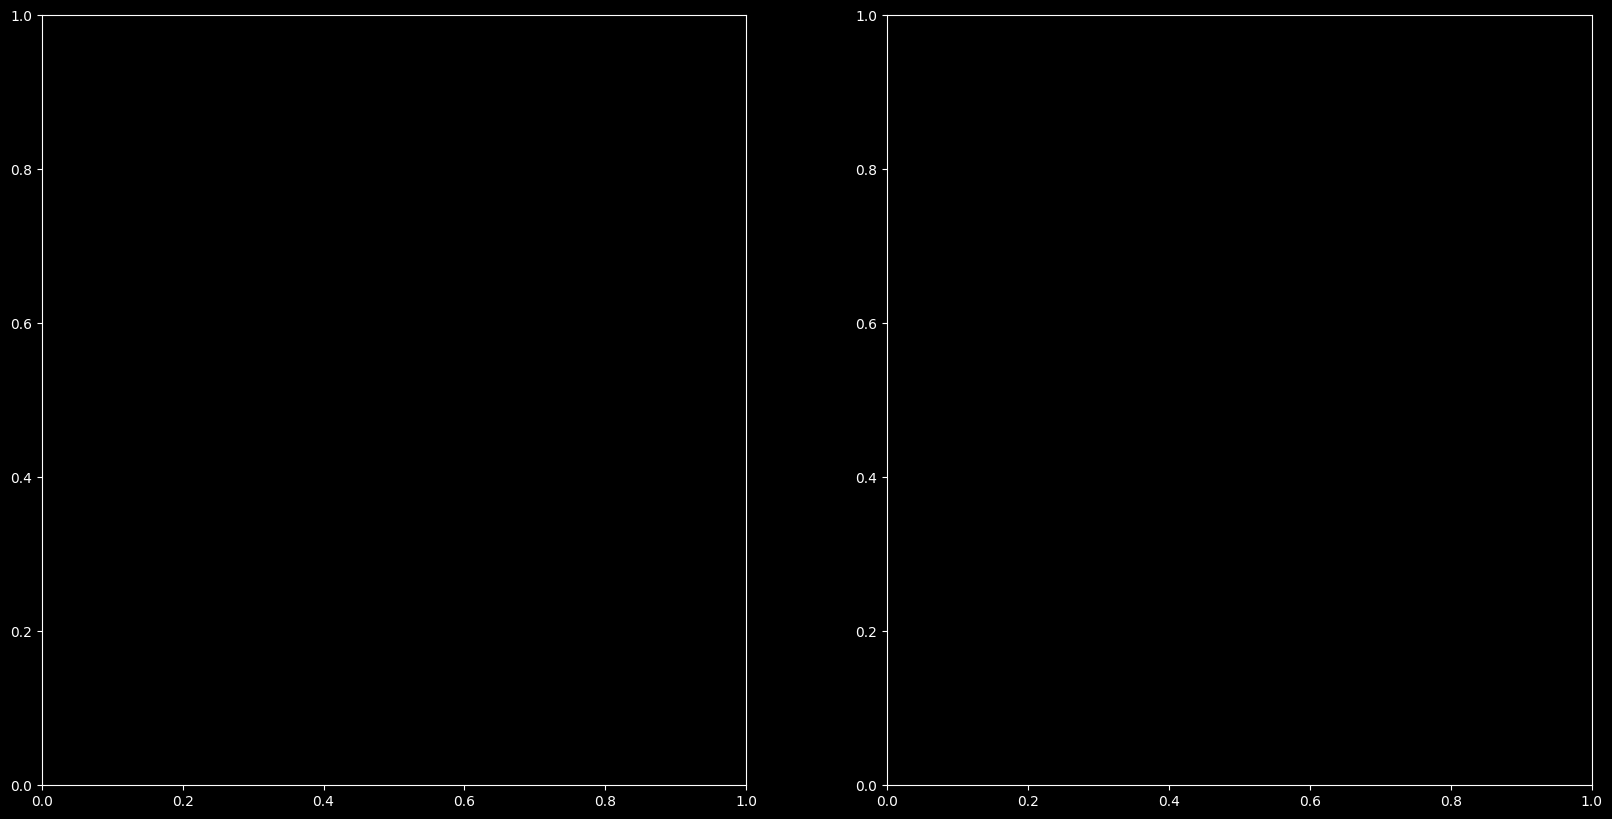

In [6]:
graph = manager.graph

if graph and graph.nodes():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    
    # Precompute layout if graph structure is stable
    pos = nx.spring_layout(graph, seed=42, k=2)
    
    # Node labels based on segment type and depth limit
    def generate_node_labels(graph, manager, depth_limit=3):
        labels = {}
        def generate_labels_rec(node, depth):
            if depth <= depth_limit:
                seg = graph.nodes[node]['segment']
                hub_marker = "★" if isinstance(seg, GraphAwareSegment) and seg.is_hub_node else ""
                labels[node] = f"{hub_marker}{seg.id[:4]}...\n({seg.tag})"
                for neighbor in graph.neighbors(node):
                    if neighbor not in labels:
                        generate_labels_rec(neighbor, depth + 1)
        
        generate_labels_rec(manager.root_id, 0)
        return labels
    
    labels = generate_node_labels(graph, manager)
    
    # Node colors and sizes
    node_colors = [color_map.get(data['segment'].tag, 'gray') for _, data in graph.nodes(data=True)]
    node_sizes = [1000 + (seg.attention_density * 5000) if manager.use_graph_aware and isinstance(data['segment'], GraphAwareSegment) else 1000 for _, data in graph.nodes(data=True)]
    
    # Draw nodes and labels
    nx.draw(graph, pos, labels=labels, with_labels=True, node_size=node_sizes, node_color=node_colors, font_size=8, font_weight='bold', ax=ax1)
    ax1.set_title('Knowledge Graph with Hub Nodes (★)')
    
    # Edge type visualization
    edge_colors = {edge_type.value: color for edge_type, color in edge_colors.items()}
    
    # Draw edges by type
    for edge_type, color in edge_colors.items():
        edges_of_type = [(u, v) for u, v, d in graph.edges(data=True) if d.get('edge_type', 0) == edge_type]
        if edges_of_type:
            nx.draw_networkx_edges(graph, pos, edgelist=edges_of_type, edge_color=color, width=2, alpha=0.6, ax=ax2, connectionstyle="arc3,rad=0.1")
    
    nx.draw_networkx_nodes(graph, pos, node_color=node_colors, node_size=1000, ax=ax2)
    nx.draw_networkx_labels(graph, pos, labels={n: n[:4] for n in graph.nodes()}, font_size=8, ax=ax2)
    ax2.set_title('Graph with Edge Types')
    
    # Legend for edge types
    legend_elements = [Patch(facecolor=color, label=f'{edge_type.name} ({count})') for edge_type, count in edge_type_stats.items()]
    if legend_elements:
        ax2.legend(handles=legend_elements, loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    # Edge type statistics
    print("\nEdge Type Distribution:")
    for edge_type, count in sorted(edge_type_stats.items(), key=lambda x: x[1], reverse=True):
        print(f"  {edge_type.name if isinstance(edge_type, EdgeType) else 'UNKNOWN'}: {count}")
    
    # GraphAwareSegment statistics
    if manager.use_graph_aware:
        print("\n--- GraphAwareSegment Network Analysis ---")
        
        # Connectivity patterns
        connectivity_stats = {'isolated_nodes': 0, 'low_connectivity': 0, 'medium_connectivity': 0, 'high_connectivity': 0}
        for seg in manager.segments.values():
            total_edges = len(seg.incoming_edges) + len(seg.outgoing_edges)
            if total_edges == 0:
                connectivity_stats['isolated_nodes'] += 1
            elif total_edges <= 2:
                connectivity_stats['low_connectivity'] += 1
            elif total_edges <= 5:
                connectivity_stats['medium_connectivity'] += 1
            else:
                connectivity_stats['high_connectivity'] += 1
        
        print("\nConnectivity Distribution:")
        for category, count in connectivity_stats.items():
            print(f"  {category}: {count}")
        
        # Segments with specific edge types
        print("\nSegments with specific relationships:")
        for edge_type in interesting_types:
            segments_with_type = [(seg.id, seg.type_distribution[edge_type]) for seg in manager.segments.values() if isinstance(seg, GraphAwareSegment) and edge_type in seg.type_distribution]
            if segments_with_type:
                print(f"\n  {edge_type.name}:")
                for seg_id, count in sorted(segments_with_type, key=lambda x: x[1], reverse=True)[:3]:
                    seg = manager.segments[seg_id]
                    print(f"    {seg_id[:8]} ({count} edges): {seg.content[:40]}...")

else:
    print("No graph data to visualize.")


In [ ]:
# --- Cell 6: Phase 3 - Node Classification ---
# This phase classifies nodes as KEEP, DELETE, or TRACK

print("\n" + "="*60)
print("PHASE 3: NODE CLASSIFICATION")
print("="*60)

classification_start = time.time()

print("Classifying nodes based on importance and content...")
manager.classify()

# Count nodes by classification
classification_counts = {'KEEP': 0, 'DELETE': 0, 'TRACK': 0}
for seg in manager.segments.values():
    classification_counts[seg.tag] = classification_counts.get(seg.tag, 0) + 1

print("\nClassification results:")
for tag, count in classification_counts.items():
    percentage = (count / len(manager.segments)) * 100
    print(f"  {tag}: {count} nodes ({percentage:.1f}%)")

# Show examples of each classification
print("\nClassification examples:")
for tag in ['KEEP', 'DELETE', 'TRACK']:
    examples = [seg for seg in manager.segments.values() if seg.tag == tag][:2]
    if examples:
        print(f"\n  {tag} examples:")
        for seg in examples:
            print(f"    {seg.id[:8]}: {seg.content[:50]}...")
            if USE_GRAPH_AWARE and isinstance(seg, GraphAwareSegment):
                print(f"      Importance: {seg.metadata.get('importance', 0):.3f}, Connections: {len(seg.incoming_edges) + len(seg.outgoing_edges)}")

classification_end = time.time()
print(f"\nClassification time: {classification_end - classification_start:.2f} seconds")

# Store Phase 3 results
phase3_results = {
    'classification_time': classification_end - classification_start,
    'classification_counts': classification_counts,
    'kept_segments': [seg for seg in manager.segments.values() if seg.tag == 'KEEP']
}

# ===== FINAL PIPELINE SUMMARY =====
total_time = classification_end - start_time

print(f"\n{'='*60}")
print("COMPLETE PIPELINE SUMMARY")
print(f"{'='*60}")

print("\n--- Tree Structure ---")
print(f"Tree depth: {tree_stats['tree_depth']}")
print(f"Total nodes: {tree_stats['total_nodes']}")
print(f"Leaf nodes: {tree_stats['leaf_nodes']}")

print("\n--- Graph Structure ---")
print(f"Hierarchical edges: {hierarchical_edges}")
print(f"Semantic edges: {semantic_edges}")
print(f"Total edges: {manager.graph.number_of_edges()}")
print(f"Edge density: {manager.graph.number_of_edges() / (len(manager.segments) * (len(manager.segments) - 1)):.3f}")

print("\n--- Special Nodes ---")
print(f"Code blocks: {code_nodes}")
print(f"Math blocks: {math_nodes}")
print(f"Hub nodes: {len(hub_nodes) if 'hub_nodes' in locals() else 'N/A'}")

print("\n--- Performance ---")
print(f"Phase 1 (Tree Construction): {phase1_results['tree_construction_time']:.2f}s")
print(f"Phase 2 (Graph Enhancement): {phase2_results['graph_enhancement_time']:.2f}s")
print(f"Phase 3 (Classification): {phase3_results['classification_time']:.2f}s")
print(f"Total pipeline time: {total_time:.2f}s")
print(f"Peak memory usage: {phase1_results['peak_memory_gb']:.2f} GB")

# Store complete pipeline results
pipeline_results = {
    'manager': manager,
    'phase1_results': phase1_results,
    'phase2_results': phase2_results,
    'phase3_results': phase3_results,
    'total_time': total_time,
    'use_graph_aware': USE_GRAPH_AWARE
}

print("\n✓ Complete pipeline finished: Tape → Tree → Graph → Classified Nodes")


PHASE 3: NODE CLASSIFICATION
Classifying nodes based on importance and content...

Classification results:
  KEEP: 177 nodes (95.7%)
  DELETE: 5 nodes (2.7%)
  TRACK: 3 nodes (1.6%)

Classification examples:

  KEEP examples:
    22f9ee70: Compare this condense version, what do you think?
...
      Importance: 0.004, Connections: 13
    8985de63: **Head Specialization Discovery**
```python
def di...
      Importance: 0.005, Connections: 71

  DELETE examples:
    c940e2aa: **Attention head manipulation** through instructio...
      Importance: 0.002, Connections: 6
    74ec9405: **Attention head manipulation** through instructio...
      Importance: 0.002, Connections: 6

  TRACK examples:
    aaf0a65c: Compare this condense version, what do you think?
...
      Importance: 0.023, Connections: 119
    586dfd2c: Key concept (short)
            2. Category (code/...
      Importance: 0.006, Connections: 81

Classification time: 0.08 seconds

COMPLETE PIPELINE SUMMARY

--- Tree Structure

In [ ]:
# --- Cell 7: GAP-Enhanced Document Reconstruction (Graph to Tape) ---
# This phase uses QwQ model with GAP for reconstruction AFTER graph is built
print("=== GAP-ENHANCED DOCUMENT RECONSTRUCTION ===")
from tqdm import tqdm

# ==== MEMORY CLEANUP BEFORE RECONSTRUCTION ====
print("\n--- Pre-Reconstruction Memory Cleanup ---")
if device.type == 'cuda':
    before_cleanup = torch.cuda.memory_allocated() / 1024**3
    torch.cuda.empty_cache()
    after_cleanup = torch.cuda.memory_allocated() / 1024**3
    print(f"GPU memory cleaned: {before_cleanup:.2f}GB -> {after_cleanup:.2f}GB")
gc.collect()

# Import optimized modules for GAP
from models.low_rank_attention import (
    LowRankAttention, BlockwiseLowRankAttention, 
    AdaptiveRankSelector, SparseAttentionProcessor
)

# Initialize GAP components (only used for reconstruction)
print("\nInitializing GAP components for reconstruction...")
attention_calculator = AttentionCalculator(
    rank_ratio=0.1,
    boundary_threshold=0.3,
    node_attention_weight=0.5
)

# Force model to load if not already loaded
if not hasattr(segmenter_model, 'config') or segmenter_model.config is None:
    print("Loading QwQ model configuration for GAP...")
    segmenter_model._lazy_load()

# Initialize optimized components for GAP reconstruction
d_model = segmenter_model.config.hidden_size if segmenter_model.config else 4096
n_heads = segmenter_model.config.num_attention_heads if segmenter_model.config else 32

# Create optimized attention processors
low_rank_attn = LowRankAttention(d_model=d_model, n_heads=n_heads, max_rank=256).to(device)
block_attn = BlockwiseLowRankAttention(d_model=d_model, n_heads=n_heads, block_size=64).to(device)
rank_selector = AdaptiveRankSelector(min_rank=32, max_rank=256)
sparse_processor = SparseAttentionProcessor(sparsity_threshold=0.01)

# Store these in segmenter_model for use in GAP methods
segmenter_model.low_rank_attn = low_rank_attn
segmenter_model.block_attn = block_attn
segmenter_model.rank_selector = rank_selector
segmenter_model.sparse_processor = sparse_processor

# Initialize document builder
doc_builder = TransformerDocumentBuilder(
    model=segmenter_model.model,
    tokenizer=segmenter_model.tokenizer
)

# Get KEPT segments from classification
kept_segments = phase3_results['kept_segments']
print(f"\nOriginal kept segments: {len(kept_segments)}")

# ==== LIMIT CONTEXT SIZE TO PREVENT OOM ====
MAX_SEGMENTS_FOR_RECONSTRUCTION = 30  # Limit to top 30 most important segments
if len(kept_segments) > MAX_SEGMENTS_FOR_RECONSTRUCTION:
    print(f"\nLimiting to top {MAX_SEGMENTS_FOR_RECONSTRUCTION} most important segments to prevent OOM")
    # Sort by importance and take top N
    kept_segments_sorted = sorted(kept_segments, 
                                 key=lambda s: s.metadata.get('importance', 0), 
                                 reverse=True)
    kept_segments = kept_segments_sorted[:MAX_SEGMENTS_FOR_RECONSTRUCTION]
    print(f"Selected segments importance range: {kept_segments[0].metadata.get('importance', 0):.3f} to {kept_segments[-1].metadata.get('importance', 0):.3f}")

print(f"\nReconstructing from {len(kept_segments)} kept segments")

# Apply GAP analysis on the constructed graph
print("\nApplying GAP analysis on constructed graph...")
gap_start_time = time.time()

# Convert segments to format for dual-level analysis
gap_segments = []
for i, seg in enumerate(kept_segments):
    gap_segments.append({
        'id': seg.id,
        'content': seg.content,
        'start_pos': seg.start_pos,
        'end_pos': seg.end_pos,
        'has_code': seg.has_code,
        'has_math': seg.has_math,
        'importance': seg.metadata.get('importance', 0.0)
    })

# Extract dual-level attention for reconstruction
print("Extracting dual-level attention patterns for reconstruction...")
with tqdm(total=1, desc="GAP analysis") as pbar:
    try:
        # Reconstruct full text for GAP analysis
        reconstruction_text = '\n'.join([seg.content for seg in kept_segments])
        
        # Use GAP to analyze the graph structure
        gap_results = segmenter_model.extract_dual_level_attention(
            text=reconstruction_text,
            segments=gap_segments,
            window_size=1024,
            rank_ratio=0.1,
            calculator=attention_calculator,
            fast_mode=True
        )
        
        # Get analysis results
        gap_analysis = attention_calculator.get_dual_level_results()
        pbar.update(1)
        
    except Exception as e:
        print(f"Warning: GAP analysis failed: {str(e)}")
        gap_analysis = {}

gap_time = time.time() - gap_start_time
print(f"GAP analysis completed in {gap_time:.2f}s")

# Build graph data structure for document builder with GAP insights
graph_data = {
    'nodes': [],
    'edges': []
}

# Add nodes with GAP-enhanced metadata
print("\nEnhancing nodes with GAP insights...")
for seg in kept_segments:
    node_data = {
        'id': seg.id,
        'content': seg.content,
        'importance': seg.metadata.get('importance', 0.0),
        'segment_type': 'technical_core' if seg.has_code else 'foundational',
        'has_code': seg.has_code,
        'has_math': seg.has_math,
        'parent': seg.parent,
        'children': seg.children
    }
    
    # Add GAP-specific enhancements if available
    if gap_analysis and 'dual_level_analysis' in gap_analysis:
        # Add cohesion scores
        if 'segment_cohesion' in gap_analysis['dual_level_analysis']:
            cohesion_data = gap_analysis['dual_level_analysis']['segment_cohesion']
            node_data['cohesion'] = cohesion_data.get('mean_cohesion', 0.0)
        
        # Mark hub nodes based on GAP analysis
        if 'node_patterns' in gap_analysis['dual_level_analysis']:
            node_patterns = gap_analysis['dual_level_analysis']['node_patterns']
            if isinstance(node_patterns, dict) and 'total_hubs' in node_patterns:
                node_data['is_gap_hub'] = node_patterns.get('total_hubs', 0) > 0
    
    # Also use GraphAwareSegment hub status if available
    if isinstance(seg, GraphAwareSegment):
        node_data['is_graph_hub'] = seg.is_hub_node
        node_data['attention_density'] = seg.attention_density
    
    graph_data['nodes'].append(node_data)

# Add edges between kept nodes only
kept_ids = {seg.id for seg in kept_segments}
edges_added = 0
for u, v, data in manager.graph.edges(data=True):
    if u in kept_ids and v in kept_ids:
        edge_data = {
            'source': u,
            'target': v,
            'weight': data.get('weight', 1.0),
            'type': EdgeType(data.get('edge_type', 0)).name,
            'edge_type_value': data.get('edge_type', 0)
        }
        graph_data['edges'].append(edge_data)
        edges_added += 1

print(f"Graph has {len(graph_data['nodes'])} nodes and {edges_added} edges")

# Define G-rules for different reconstruction strategies
g_rules = {
    'technical_summary': "Create a technical summary focusing on implementations and code examples",
    'conceptual_overview': "Create a high-level conceptual overview of the main ideas",
    'tutorial': "Create a step-by-step tutorial based on the content"
}

# Generate with multiple strategies using GAP insights
reassembled_texts = {}
print("\nGenerating reconstructed documents...")

for g_key, g_rule in g_rules.items():
    print(f"\nGenerating {g_key}...")
    generation_start = time.time()
    
    # Skip TransformerDocumentBuilder due to missing methods
    # Use TransformerDocumentBuilder for GAP-aware generation
    # strategy = 'guided' if 'summary' in g_key else 'narrative'
    
    # Pass GAP analysis to the builder
    # if gap_analysis:
    #     graph_data['gap_analysis'] = gap_analysis
    
    # reassembled_text = doc_builder.build_document(graph_data, strategy=strategy)
    # reassembled_texts[g_key] = reassembled_text
    
    # Use PartitionManager's reassemble instead
    try:
        pm_text = manager.reassemble(g_rule, g_key, segmenter_model)
        reassembled_texts[f"{g_key}_pm"] = pm_text
        print(f"  PartitionManager: {len(pm_text)} chars")
    except torch.cuda.OutOfMemoryError:
        print(f"  OOM error for {g_key}, skipping...")
        reassembled_texts[f"{g_key}_pm"] = "Generation failed due to memory constraints"
    
    generation_time = time.time() - generation_start
    print(f"  Generation time: {generation_time:.2f}s")
    
    # Clear GPU cache after each generation
    if device.type == 'cuda':
        torch.cuda.empty_cache()

# Save results
output_dir = Path('results')
output_dir.mkdir(exist_ok=True)

# Save best result
best_key = 'technical_summary'
with open(output_dir / 'gap_enhanced_output.txt', 'w') as f:
    f.write(f"# GAP-Enhanced Reconstruction\n")
    f.write(f"Strategy: {best_key}\n")
    f.write(f"Nodes: {len(graph_data['nodes'])}\n")
    f.write(f"Edges: {len(graph_data['edges'])}\n")
    f.write(f"GAP Processing Time: {gap_time:.2f}s\n\n")
    f.write(reassembled_texts.get(f"{best_key}_pm", "No output generated"))

# Save comparison
with open(output_dir / 'reconstruction_comparison.json', 'w') as f:
    comparison = {
        'strategies': list(g_rules.keys()),
        'lengths': {k: len(v) for k, v in reassembled_texts.items()},
        'graph_stats': {
            'total_segments': len(manager.segments),
            'kept_segments_original': len(phase3_results['kept_segments']),
            'kept_segments_used': len(kept_segments),
            'edges_in_kept_graph': edges_added
        },
        'gap_processing_time': gap_time,
        'has_gap_analysis': bool(gap_analysis)
    }
    json.dump(comparison, f, indent=2)

print(f"\nResults saved to {output_dir}")

# Display GAP insights if available
if gap_analysis and 'dual_level_analysis' in gap_analysis:
    print("\n=== GAP Analysis Insights ===")
    dual_analysis = gap_analysis['dual_level_analysis']
    
    if 'segment_cohesion' in dual_analysis:
        cohesion = dual_analysis['segment_cohesion']
        print(f"Segment Cohesion: mean={cohesion.get('mean_cohesion', 0):.3f}, "
              f"variance={cohesion.get('cohesion_variance', 0):.3f}")
    
    if 'node_patterns' in dual_analysis:
        patterns = dual_analysis['node_patterns']
        if isinstance(patterns, dict):
            print(f"Node Patterns: hubs={patterns.get('total_hubs', 0)}, "
                  f"clustering={patterns.get('mean_clustering', 0):.3f}")
    
    if 'cross_level_patterns' in dual_analysis:
        cross = dual_analysis['cross_level_patterns']
        if isinstance(cross, dict):
            print(f"Cross-Level: consistency={cross.get('mean_consistency', 0):.3f}, "
                  f"attention={cross.get('mean_cross_attention', 0):.3f}")

# Final memory cleanup
if device.type == 'cuda':
    final_mem = torch.cuda.memory_allocated() / 1024**3
    print(f"\nFinal GPU memory usage: {final_mem:.2f}GB")

print("\n=== GAP-Enhanced Reconstruction Complete ===")

=== GAP-ENHANCED DOCUMENT RECONSTRUCTION ===

--- Pre-Reconstruction Memory Cleanup ---
GPU memory cleaned: 26.50GB -> 26.50GB

Initializing GAP components for reconstruction...
Loading QwQ model configuration for GAP...
Model device: meta
Model device after loading: cuda:0

Original kept segments: 177

Limiting to top 30 most important segments to prevent OOM
Selected segments importance range: 0.007 to 0.007

Reconstructing from 30 kept segments

Applying GAP analysis on constructed graph...
Extracting dual-level attention patterns for reconstruction...


GAP analysis:   0%|          | 0/1 [00:00<?, ?it/s]
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


GAP analysis completed in 0.76s

Enhancing nodes with GAP insights...
Graph has 30 nodes and 379 edges

Generating reconstructed documents...

Generating technical_summary...


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


  OOM error for technical_summary, skipping...
  Generation time: 0.29s

Generating conceptual_overview...
  OOM error for conceptual_overview, skipping...
  Generation time: 0.19s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.



Generating tutorial...
  OOM error for tutorial, skipping...
  Generation time: 0.18s

Results saved to results

Final GPU memory usage: 87.53GB

=== GAP-Enhanced Reconstruction Complete ===


In [ ]:
# --- Cell 6: GAP Analysis Visualization ---
print("=== GAP Dual-Level Analysis ===")

if hasattr(manager, 'gap_analysis') and manager.gap_analysis:
    gap_data = manager.gap_analysis['full_analysis']
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Segment Cohesion Scores
    if 'segment_cohesion' in gap_data:
        cohesion_scores = [(s['segment_id'][:8], s['cohesion']) 
                          for s in gap_data['segment_cohesion'][:20]]  # Top 20
        ids, scores = zip(*cohesion_scores) if cohesion_scores else ([], [])
        axes[0, 0].barh(range(len(scores)), scores)
        axes[0, 0].set_yticks(range(len(ids)))
        axes[0, 0].set_yticklabels(ids)
        axes[0, 0].set_xlabel('Cohesion Score')
        axes[0, 0].set_title('Top Segment Cohesion Scores')
    
    # 2. Node Pattern Analysis
    if 'node_patterns' in gap_data and gap_data['node_patterns']:
        pattern = gap_data['node_patterns'][0]['patterns']
        metrics_text = f"Hub Nodes: {pattern.get('num_hubs', 0)}\n"
        metrics_text += f"Clustering Coeff: {pattern.get('clustering_coefficient', 0):.3f}\n"
        metrics_text += f"Graph Density: {pattern.get('graph_density', 0):.3f}\n"
        metrics_text += f"Components: {pattern.get('num_components', 0)}"
        axes[0, 1].text(0.1, 0.5, metrics_text, transform=axes[0, 1].transAxes,
                       fontsize=12, verticalalignment='center')
        axes[0, 1].set_title('Node-Level Graph Metrics')
        axes[0, 1].axis('off')
    
    # 3. Boundary Detection Comparison
    if 'segment_boundaries' in gap_data and 'dual_level_boundaries' in gap_data:
        trad_boundaries = [b['position'] for b in gap_data['segment_boundaries']]
        dual_boundaries = [b['position'] for b in gap_data['dual_level_boundaries']]
        
        axes[1, 0].scatter(trad_boundaries, [1]*len(trad_boundaries), 
                          label='Traditional', s=50)
        axes[1, 0].scatter(dual_boundaries, [2]*len(dual_boundaries), 
                          label='Dual-Level', s=50)
        axes[1, 0].set_ylim(0.5, 2.5)
        axes[1, 0].set_xlabel('Token Position')
        axes[1, 0].set_title('Boundary Detection Methods')
        axes[1, 0].legend()
    
    # 4. Attention Pattern Summary
    if 'attention_summary' in gap_data:
        summary = gap_data['attention_summary']
        summary_text = f"Windows Processed: {summary.get('total_windows', 0)}\n"
        summary_text += f"Boundaries Found: {summary.get('boundary_count', 0)}\n"
        summary_text += f"Avg Entropy: {summary.get('average_entropy', 0):.3f}\n"
        summary_text += f"Pattern Coherence: {summary.get('pattern_coherence', 0):.3f}"
        axes[1, 1].text(0.1, 0.5, summary_text, transform=axes[1, 1].transAxes,
                       fontsize=12, verticalalignment='center')
        axes[1, 1].set_title('Attention Pattern Summary')
        axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("No GAP analysis data available.")

=== GAP Dual-Level Analysis ===
No GAP analysis data available.


In [ ]:
# --- Cell 7: GAP-Enhanced Document Reassembly (Graph to Tape) ---
print("=== GAP-Enhanced Document Reassembly ===")
from tqdm import tqdm

# Import optimized modules for GAP
from models.low_rank_attention import (
    LowRankAttention, BlockwiseLowRankAttention, 
    AdaptiveRankSelector, SparseAttentionProcessor
)

# Force model to load if not already loaded
if not hasattr(segmenter_model, 'config') or segmenter_model.config is None:
    print("Loading model configuration for GAP...")
    segmenter_model._lazy_load()

# Initialize optimized components for GAP reconstruction
print("Initializing GAP attention modules...")
d_model = segmenter_model.config.hidden_size if segmenter_model.config else 4096
n_heads = segmenter_model.config.num_attention_heads if segmenter_model.config else 32

# Create optimized attention processors
low_rank_attn = LowRankAttention(d_model=d_model, n_heads=n_heads, max_rank=256).to(device)
block_attn = BlockwiseLowRankAttention(d_model=d_model, n_heads=n_heads, block_size=64).to(device)
rank_selector = AdaptiveRankSelector(min_rank=32, max_rank=256)
sparse_processor = SparseAttentionProcessor(sparsity_threshold=0.01)

# Store these in segmenter_model for use in GAP methods
segmenter_model.low_rank_attn = low_rank_attn
segmenter_model.block_attn = block_attn
segmenter_model.rank_selector = rank_selector
segmenter_model.sparse_processor = sparse_processor

# Initialize document builder
doc_builder = TransformerDocumentBuilder(
    model=segmenter_model.model,
    tokenizer=segmenter_model.tokenizer
)

# Prepare graph data from PartitionManager
kept_segments = [seg for seg in manager.segments.values() if seg.tag == 'KEEP']
print(f"Reassembling from {len(kept_segments)} kept segments")

# Now apply GAP analysis on the constructed graph
print("\nApplying GAP analysis on constructed graph...")
gap_start_time = time.time()

# Convert segments to format for dual-level analysis
gap_segments = []
for i, seg in enumerate(kept_segments):
    gap_segments.append({
        'id': seg.id,
        'content': seg.content,
        'start_pos': seg.start_pos,
        'end_pos': seg.end_pos,
        'has_code': seg.has_code,
        'has_math': seg.has_math,
        'importance': seg.metadata.get('importance', 0.0)
    })

# Extract dual-level attention for reconstruction
print("Extracting dual-level attention patterns for reconstruction...")
with tqdm(total=1, desc="GAP analysis") as pbar:
    try:
        # Reconstruct full text for GAP analysis
        reconstruction_text = '\n'.join([seg.content for seg in kept_segments])
        
        # Use GAP to analyze the graph structure
        gap_results = segmenter_model.extract_dual_level_attention(
            text=reconstruction_text,
            segments=gap_segments,
            window_size=1024,
            rank_ratio=0.1,
            calculator=attention_calculator,
            fast_mode=True
        )
        
        # Get analysis results
        gap_analysis = attention_calculator.get_dual_level_results()
        pbar.update(1)
        
    except Exception as e:
        print(f"Warning: GAP analysis failed: {str(e)}")
        gap_analysis = {}

gap_time = time.time() - gap_start_time
print(f"GAP analysis completed in {gap_time:.2f}s")

# Build graph data structure for document builder with GAP insights
graph_data = {
    'nodes': [],
    'edges': []
}

# Add nodes with GAP-enhanced metadata
print("\nEnhancing nodes with GAP insights...")
for seg in kept_segments:
    node_data = {
        'id': seg.id,
        'content': seg.content,
        'importance': seg.metadata.get('importance', 0.0),
        'segment_type': 'technical_core' if seg.has_code else 'foundational',
        'has_code': seg.has_code,
        'has_math': seg.has_math,
        'parent': seg.parent,
        'children': seg.children
    }
    
    # Add GAP-specific enhancements if available
    if gap_analysis and 'dual_level_analysis' in gap_analysis:
        # Add cohesion scores
        if 'segment_cohesion' in gap_analysis['dual_level_analysis']:
            cohesion_data = gap_analysis['dual_level_analysis']['segment_cohesion']
            node_data['cohesion'] = cohesion_data.get('mean_cohesion', 0.0)
        
        # Mark hub nodes
        if 'node_patterns' in gap_analysis['dual_level_analysis']:
            node_patterns = gap_analysis['dual_level_analysis']['node_patterns']
            if isinstance(node_patterns, dict) and 'total_hubs' in node_patterns:
                node_data['is_hub'] = node_patterns.get('total_hubs', 0) > 0
    
    graph_data['nodes'].append(node_data)

# Add edges between kept nodes only
kept_ids = {seg.id for seg in kept_segments}
edges_added = 0
for u, v, data in manager.graph.edges(data=True):
    if u in kept_ids and v in kept_ids:
        edge_data = {
            'source': u,
            'target': v,
            'weight': data.get('weight', 1.0),
            'type': EdgeType(data.get('edge_type', 0)).name,
            'edge_type_value': data.get('edge_type', 0)
        }
        graph_data['edges'].append(edge_data)
        edges_added += 1

print(f"Graph has {len(graph_data['nodes'])} nodes and {edges_added} edges")

# Define G-rules for different reassembly strategies
g_rules = {
    'technical_summary': "Create a technical summary focusing on implementations and code examples",
    'conceptual_overview': "Create a high-level conceptual overview of the main ideas",
    'tutorial': "Create a step-by-step tutorial based on the content"
}

# Generate with multiple strategies using GAP insights
reassembled_texts = {}
print("\nGenerating reassembled documents...")

for g_key, g_rule in g_rules.items():
    print(f"\nGenerating {g_key}...")
    generation_start = time.time()
    
    # Use TransformerDocumentBuilder for GAP-aware generation
    strategy = 'guided' if 'summary' in g_key else 'narrative'
    
    # Pass GAP analysis to the builder
    if gap_analysis:
        graph_data['gap_analysis'] = gap_analysis
    
    reassembled_text = doc_builder.build_document(graph_data, strategy=strategy)
    reassembled_texts[g_key] = reassembled_text
    
    # Also use PartitionManager's reassemble for comparison
    pm_text = manager.reassemble(g_rule, g_key, segmenter_model)
    reassembled_texts[f"{g_key}_pm"] = pm_text
    
    generation_time = time.time() - generation_start
    print(f"  TransformerDocBuilder: {len(reassembled_text)} chars ({generation_time:.2f}s)")
    print(f"  PartitionManager: {len(pm_text)} chars")

# Save results
output_dir = Path('results')
output_dir.mkdir(exist_ok=True)

# Save best result
best_key = 'technical_summary'
with open(output_dir / 'gap_enhanced_output.txt', 'w') as f:
    f.write(f"# GAP-Enhanced Reassembly\n")
    f.write(f"Strategy: {best_key}\n")
    f.write(f"Nodes: {len(graph_data['nodes'])}\n")
    f.write(f"Edges: {len(graph_data['edges'])}\n")
    f.write(f"GAP Processing Time: {gap_time:.2f}s\n\n")
    f.write(reassembled_texts[best_key])

# Save comparison
with open(output_dir / 'reassembly_comparison.json', 'w') as f:
    comparison = {
        'strategies': list(g_rules.keys()),
        'lengths': {k: len(v) for k, v in reassembled_texts.items()},
        'graph_stats': {
            'total_segments': len(manager.segments),
            'kept_segments': len(kept_segments),
            'edges_in_kept_graph': edges_added
        },
        'gap_processing_time': gap_time,
        'has_gap_analysis': bool(gap_analysis)
    }
    json.dump(comparison, f, indent=2)

print(f"\nResults saved to {output_dir}")

# Display GAP insights if available
if gap_analysis and 'dual_level_analysis' in gap_analysis:
    print("\n=== GAP Analysis Insights ===")
    dual_analysis = gap_analysis['dual_level_analysis']
    
    if 'segment_cohesion' in dual_analysis:
        cohesion = dual_analysis['segment_cohesion']
        print(f"Segment Cohesion: mean={cohesion.get('mean_cohesion', 0):.3f}, "
              f"variance={cohesion.get('cohesion_variance', 0):.3f}")
    
    if 'node_patterns' in dual_analysis:
        patterns = dual_analysis['node_patterns']
        if isinstance(patterns, dict):
            print(f"Node Patterns: hubs={patterns.get('total_hubs', 0)}, "
                  f"clustering={patterns.get('mean_clustering', 0):.3f}")
    
    if 'cross_level_patterns' in dual_analysis:
        cross = dual_analysis['cross_level_patterns']
        if isinstance(cross, dict):
            print(f"Cross-Level: consistency={cross.get('mean_consistency', 0):.3f}, "
                  f"attention={cross.get('mean_cross_attention', 0):.3f}")

print("\n=== GAP-Enhanced Reassembly Complete ===")

=== GAP-Enhanced Document Reassembly ===
Initializing GAP attention modules...
Reassembling from 177 kept segments

Applying GAP analysis on constructed graph...
Extracting dual-level attention patterns for reconstruction...


GAP analysis:   0%|          | 0/1 [00:00<?, ?it/s]

GAP analysis completed in 0.74s

Enhancing nodes with GAP insights...
Graph has 177 nodes and 5174 edges

Generating reassembled documents...

Generating technical_summary...



Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


OutOfMemoryError: CUDA out of memory. Tried to allocate 5.07 GiB. GPU 0 has a total capacity of 94.97 GiB of which 3.74 GiB is free. Including non-PyTorch memory, this process has 91.22 GiB memory in use. Of the allocated memory 90.56 GiB is allocated by PyTorch, and 4.63 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
# --- Cell 8: Comprehensive Analysis ---
print("=== Final Analysis ===")

# Compute comprehensive metrics
analysis_results = {
    'graph_metrics': compute_graph_metrics(manager.graph), 
    'kept_ratio': len(kept_segments) / len(manager.segments),
    'compression_ratio': len(reassembled_texts[best_key]) / len(pipeline_text),
    'edge_density': manager.graph.number_of_edges() / (len(manager.segments) ** 2),
    'gap_enhancements': {
        'dual_level_boundaries': len(gap_data.get('dual_level_boundaries', [])) if 'gap_data' in locals() else 0,
        'cohesive_segments': sum(1 for seg in manager.segments.values() 
                                if seg.metadata.get('cohesion', 0) > 0.5),
        'typed_edges': sum(1 for _, _, d in manager.graph.edges(data=True) 
                          if d.get('edge_type', 0) != EdgeType.NO_RELATION.value)
    }
}

# Display results
print("\n--- Graph Metrics ---")
for key, value in analysis_results['graph_metrics'].items():
    if key not in ['pagerank', 'in_degree_centrality', 'out_degree_centrality', 'top_nodes']:
        print(f"{key}: {value}")

print("\n--- Compression & Quality ---")
print(f"Kept segments: {analysis_results['kept_ratio']:.1%}")
print(f"Text compression: {analysis_results['compression_ratio']:.1%}")
print(f"Edge density: {analysis_results['edge_density']:.3f}")

print("\n--- GAP Enhancements ---")
for key, value in analysis_results['gap_enhancements'].items():
    print(f"{key}: {value}")

# Save comprehensive analysis
with open(output_dir / 'gap_analysis.json', 'w') as f:
    # Convert non-serializable items
    save_results = analysis_results.copy()
    if 'graph_metrics' in save_results:
        metrics = save_results['graph_metrics'].copy()
        # Convert node-based dicts to lists of top items
        if 'pagerank' in metrics:
            metrics['top_pagerank'] = sorted(
                [(k, v) for k, v in metrics['pagerank'].items()],
                key=lambda x: x[1], reverse=True
            )[:10]
            del metrics['pagerank']
        if 'in_degree_centrality' in metrics:
            del metrics['in_degree_centrality']
        if 'out_degree_centrality' in metrics:
            del metrics['out_degree_centrality']
        save_results['graph_metrics'] = metrics
    
    json.dump(save_results, f, indent=2)

print(f"\nAnalysis saved to {output_dir / 'gap_analysis.json'}")

# Create summary visualization
plt.figure(figsize=(10, 6))
categories = ['Original', 'Kept', 'Reassembled']
sizes = [
    len(pipeline_text),
    sum(len(seg.content) for seg in kept_segments),
    len(reassembled_texts[best_key])
]
colors = ['lightblue', 'lightgreen', 'gold']

plt.bar(categories, sizes, color=colors)
plt.title('Text Size Through Pipeline')
plt.ylabel('Characters')
for i, size in enumerate(sizes):
    plt.text(i, size + 1000, f'{size:,}', ha='center')

plt.tight_layout()
plt.show()

print("\n=== Pipeline Complete ===")

In [ ]:
# --- Cell 9: Demonstrate Graph Analysis ---
print("=== Graph Structure Analysis ===")

# Basic graph metrics
print(f"\nGraph Statistics:")
print(f"- Total nodes: {len(manager.segments)}")
print(f"- Total edges: {manager.graph.number_of_edges()}")
print(f"- Node types:")
for tag in ['KEEP', 'DELETE', 'TRACK']:
    count = sum(1 for seg in manager.segments.values() if seg.tag == tag)
    print(f"  - {tag}: {count} ({count/len(manager.segments)*100:.1f}%)")

# Analyze edge type distribution
edge_type_stats = {}
for _, _, data in manager.graph.edges(data=True):
    edge_type = data.get('edge_type', 0)
    edge_type_stats[edge_type] = edge_type_stats.get(edge_type, 0) + 1

print(f"\nEdge Type Distribution:")
for edge_type_val, count in sorted(edge_type_stats.items(), key=lambda x: x[1], reverse=True):
    try:
        edge_type_name = EdgeType(edge_type_val).name
    except:
        edge_type_name = 'UNKNOWN'
    print(f"  - {edge_type_name}: {count}")

# Find most connected nodes
node_connections = {}
for node_id in manager.graph.nodes():
    in_degree = manager.graph.in_degree(node_id)
    out_degree = manager.graph.out_degree(node_id)
    node_connections[node_id] = in_degree + out_degree

print(f"\nMost Connected Nodes (Hubs):")
top_nodes = sorted(node_connections.items(), key=lambda x: x[1], reverse=True)[:5]
for node_id, connections in top_nodes:
    segment = manager.segments[node_id]
    print(f"  - {node_id[:8]}: {connections} connections")
    print(f"    Content preview: {segment.content[:60]}...")
    print(f"    Tag: {segment.tag}, Importance: {segment.metadata.get('importance', 0):.3f}")

# Analyze graph connectivity
is_connected = nx.is_weakly_connected(manager.graph)
num_components = nx.number_weakly_connected_components(manager.graph)
print(f"\nGraph Connectivity:")
print(f"  - Is connected: {is_connected}")
print(f"  - Number of components: {num_components}")

if not is_connected:
    # Find largest component
    components = list(nx.weakly_connected_components(manager.graph))
    largest_component = max(components, key=len)
    print(f"  - Largest component size: {len(largest_component)} nodes")

# Visualize node importance distribution
importances = [seg.metadata.get('importance', 0) for seg in manager.segments.values()]

plt.figure(figsize=(10, 6))
plt.hist(importances, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.axvline(np.mean(importances), color='red', linestyle='--', 
            label=f'Mean: {np.mean(importances):.3f}')
plt.xlabel('Importance Score')
plt.ylabel('Count')
plt.title('Distribution of Node Importance Scores')
plt.legend()
plt.tight_layout()
plt.show()

# Create a simplified graph visualization
plt.figure(figsize=(12, 8))

# Create subgraph of most important nodes for visualization
important_nodes = [node_id for node_id, seg in manager.segments.items() 
                  if seg.metadata.get('importance', 0) > np.percentile(importances, 75)]

if len(important_nodes) > 20:
    important_nodes = important_nodes[:20]  # Limit for readability

subgraph = manager.graph.subgraph(important_nodes)
pos = nx.spring_layout(subgraph, k=2, iterations=50, seed=42)

# Node colors by tag
color_map = {'KEEP': 'lightgreen', 'DELETE': 'lightcoral', 'TRACK': 'lightyellow'}
node_colors = [color_map.get(manager.segments[n].tag, 'gray') for n in subgraph.nodes()]

# Draw graph
nx.draw_networkx_nodes(subgraph, pos, node_color=node_colors, 
                      node_size=1000, alpha=0.8)
nx.draw_networkx_edges(subgraph, pos, edge_color='gray', 
                      width=1, alpha=0.5, arrows=True)

# Add labels
labels = {}
for node in subgraph.nodes():
    content = manager.segments[node].content
    # Truncate and clean content for label
    label = content[:20].replace('\n', ' ') + '...'
    labels[node] = label

nx.draw_networkx_labels(subgraph, pos, labels, font_size=8)

plt.title('Graph Structure Visualization (Top Important Nodes)')
plt.axis('off')
plt.tight_layout()
plt.show()

print("\n=== Graph Analysis Complete ===")

In [ ]:
# --- Cell 10: Export Graph Data ---
print("=== Exporting Graph Data ===")

# Create comprehensive export structure
export_data = {
    'metadata': {
        'total_segments': len(manager.segments),
        'total_edges': manager.graph.number_of_edges(),
        'processing_times': manager.analysis_metadata if hasattr(manager, 'analysis_metadata') else {},
        'rules_applied': segmentation_rules,
        'similarity_threshold': manager.similarity_threshold
    },
    'segments': [],
    'edges': [],
    'graph_structure': {
        'nodes': [],
        'edges': []
    }
}

# Export segments
for seg_id, segment in manager.segments.items():
    seg_data = {
        'id': segment.id,
        'content': segment.content[:200] + '...' if len(segment.content) > 200 else segment.content,
        'full_content_length': len(segment.content),
        'start_pos': segment.start_pos,
        'end_pos': segment.end_pos,
        'tag': segment.tag,
        'parent': segment.parent,
        'children': segment.children,
        'has_code': segment.has_code,
        'has_math': segment.has_math,
        'metadata': segment.metadata
    }
    export_data['segments'].append(seg_data)

# Export edges
for source_id, target_id, data in manager.graph.edges(data=True):
    edge_data = {
        'source': source_id,
        'target': target_id,
        'weight': data.get('weight', 1.0),
        'type': data.get('type', 'unknown'),
        'edge_type': EdgeType(data.get('edge_type', 0)).name if 'edge_type' in data else 'NO_RELATION'
    }
    export_data['edges'].append(edge_data)

# Export graph structure for visualization
for node_id, data in manager.graph.nodes(data=True):
    node_data = {
        'id': node_id,
        'tag': data['segment'].tag,
        'importance': data['segment'].metadata.get('importance', 0.0)
    }
    export_data['graph_structure']['nodes'].append(node_data)

for source, target, data in manager.graph.edges(data=True):
    edge_data = {
        'source': source,
        'target': target,
        'weight': data.get('weight', 1.0),
        'type': data.get('type', 'unknown'),
        'edge_type': EdgeType(data.get('edge_type', 0)).name if 'edge_type' in data else 'NO_RELATION'
    }
    export_data['graph_structure']['edges'].append(edge_data)

# Save to JSON
output_path = output_dir / 'graph_export.json'
with open(output_path, 'w') as f:
    json.dump(export_data, f, indent=2)

print(f"Exported graph data to: {output_path}")
print(f"  - Segments: {len(export_data['segments'])}")
print(f"  - Edges: {len(export_data['edges'])}")

# Create a simplified GraphML export for graph visualization tools
graphml_path = output_dir / 'graph_export.graphml'
G_export = nx.DiGraph()

# Add nodes
for seg_data in export_data['segments']:
    G_export.add_node(
        seg_data['id'],
        label=seg_data['id'][:8],
        tag=seg_data['tag'],
        content_length=seg_data['full_content_length'],
        importance=seg_data['metadata'].get('importance', 0.0)
    )

# Add edges
for edge_data in export_data['edges']:
    G_export.add_edge(
        edge_data['source'],
        edge_data['target'],
        edge_type=edge_data['edge_type'],
        weight=edge_data['weight']
    )

nx.write_graphml(G_export, graphml_path)
print(f"\nExported GraphML to: {graphml_path}")

# Create summary statistics
summary = {
    'nodes_by_tag': {},
    'edge_types': {},
    'connectivity': {
        'is_connected': nx.is_weakly_connected(manager.graph),
        'num_components': nx.number_weakly_connected_components(manager.graph),
        'density': nx.density(manager.graph)
    }
}

# Count nodes by tag
for tag in ['KEEP', 'DELETE', 'TRACK']:
    summary['nodes_by_tag'][tag] = sum(1 for seg in manager.segments.values() if seg.tag == tag)

# Count edge types
for edge in export_data['edges']:
    edge_type = edge['edge_type']
    summary['edge_types'][edge_type] = summary['edge_types'].get(edge_type, 0) + 1

# Save summary
summary_path = output_dir / 'graph_summary.json'
with open(summary_path, 'w') as f:
    json.dump(summary, f, indent=2)

print("\n--- Export Summary ---")
print(f"Nodes by tag:")
for tag, count in summary['nodes_by_tag'].items():
    print(f"  {tag}: {count}")
print(f"\nEdge types:")
for edge_type, count in sorted(summary['edge_types'].items(), key=lambda x: x[1], reverse=True):
    print(f"  {edge_type}: {count}")
print(f"\nConnectivity:")
for key, value in summary['connectivity'].items():
    print(f"  {key}: {value}")

print("\n=== Export Complete ===")